<h2>Named entity recognition</h2>
<br>
Sequence labelling: input word sequence, output tag sequence

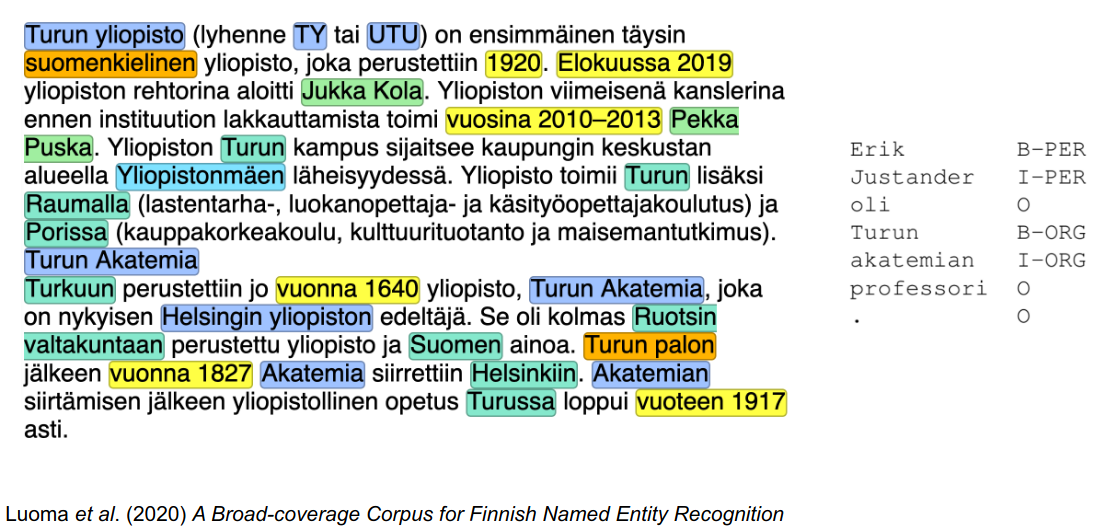

<h3>Load CoNLL'03 data</h3>

We use the CoNLL'03 dataset. The data in their original format can be found here https://github.com/glample/tagger .<br><br>

In this demo, the dataset has already been converted to json files. The converted data are found here under the file names `ner_train.json` and `ner_test.json`: https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/tree/master/data The code used for convertion can be found here: https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/read_ner.ipynb <br><br>

The data is divided into separate sentences and has also been tokenized already. You don't have to do any preprocessing. The produced json files contain a single dictionary for each sentence. The dictionary has a list of tokens and the corresponding list of labels, e.g.: { "text": [ "EU", "rejects", "German", "call", "to", "boycott", "British", "lamb", "." ], "tags": [ "I-ORG", "O", "O", "O", "O", "O", "O", "O", "O" ] },

In [1]:
import json


with open("data/ner_train.json") as f:
    data=json.load(f)

    
# Look at the data
print(type(data))
print(type(data[0]))
print(data[0].keys())
print(data[0])

<class 'list'>
<class 'dict'>
dict_keys(['text', 'tags'])
{'text': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'tags': ['I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']}


In [2]:
import random
import numpy


random.seed(123)    # This makes the shuffle produce the same order every time
random.shuffle(data)

texts=[example["text"] for example in data]
labels=[example["tags"] for example in data]

# Example text and labels
print('Text:', texts[0])
print('Label:', labels[0])

Text: ['9/16', '-', 'Luo', 'Yigang', '(', 'China', ')', 'beat', 'Jason', 'Wong', '(', 'Malaysia', ')', '15-5', '15-6']
Label: ['O', 'O', 'I-PER', 'I-PER', 'O', 'I-LOC', 'O', 'O', 'I-PER', 'I-PER', 'O', 'I-LOC', 'O', 'O', 'O']


In [3]:
# Lets do the same thing for the validation data
# We use a separate validation set, since generally using sentences from the same documents as train/validation results in overly optimistic scores
with open("data/ner_test.json") as f:
    validation_data=json.load(f)
validation_texts=[example["text"] for example in validation_data]
validation_labels=[example["tags"] for example in validation_data]

<h3>Load pretrained embeddings</h3>
<br>
We use gensim to read the embedding model.<br>
Note that we are using a vocabulary size of only 50,000 so that the model trains quickly.

In [4]:
from gensim.models import KeyedVectors

vector_model = KeyedVectors.load_word2vec_format("data/wiki-news-300d-1M.vec", binary=False, limit=50000)


# sort based on the index to make sure they are in the correct order
words=[k for k,v in sorted(vector_model.vocab.items(), key=lambda x:x[1].index)]
print("Words from embedding model:",len(words))
print("First 50 words:",words[:50])

# Normalize the vectors to unit length
print("Before normalization:",vector_model.get_vector("in")[:10])
vector_model.init_sims(replace=True)
print("After normalization:",vector_model.get_vector("in")[:10])

Words from embedding model: 50000
First 50 words: [',', 'the', '.', 'and', 'of', 'to', 'in', 'a', '"', ':', ')', 'that', '(', 'is', 'for', 'on', '*', 'with', 'as', 'it', 'The', 'or', 'was', "'", "'s", 'by', 'from', 'at', 'I', 'this', 'you', '/', 'are', '=', 'not', '-', 'have', '?', 'be', 'which', ';', 'all', 'his', 'has', 'one', 'their', 'about', 'but', 'an', '|']
Before normalization: [-0.0234 -0.0268 -0.0838  0.0386 -0.0321  0.0628  0.0281 -0.0252  0.0269
 -0.0063]
After normalization: [-0.0163762  -0.01875564 -0.05864638  0.02701372 -0.02246478  0.04394979
  0.01966543 -0.0176359   0.01882563 -0.00440898]


In [5]:
# Build vocabulary mappings

vocabulary={"<SPECIAL>": 0, "<OOV>": 1} # zero has a special meaning in sequence models, prevent using it for a normal word
for word in words: #these are words from the word2vec model
    vocabulary.setdefault(word, len(vocabulary))

print("Words in vocabulary:",len(vocabulary))
inversed_vocabulary={value:key for key, value in vocabulary.items()} # inverse the dictionary
    
                
# Embedding matrix
def load_pretrained_embeddings(vocab, embedding_model):
    """ vocab: vocabulary from our data vectorizer, embedding_model: model loaded with gensim """
    pretrained_embeddings=numpy.random.uniform(low=-0.05, high=0.05, size=(len(vocab)-1,embedding_model.vectors.shape[1]))
    pretrained_embeddings = numpy.vstack((numpy.zeros(shape=(1,embedding_model.vectors.shape[1])), pretrained_embeddings))
    found=0
    for word,idx in vocab.items():
        if word in embedding_model.vocab:
            pretrained_embeddings[idx]=embedding_model.get_vector(word)
            found+=1
            
    print("Found pretrained vectors for {found} words.".format(found=found))
    return pretrained_embeddings

pretrained=load_pretrained_embeddings(vocabulary, vector_model)

Words in vocabulary: 50002
Found pretrained vectors for 50000 words.


<h3>Preprocess data</h3>
<br>
Both the text and the labels are strings; we'll need to convert the labels into integers and the text into an appropriate format for RNN training.<br>
<h4>Labels</h4>

In [6]:
from pprint import pprint

# Label mappings
# 1) gather a set of unique labels
label_set = set()
for sentence_labels in labels: #loops over sentences 
    for label in sentence_labels: #loops over labels in one sentence
        label_set.add(label)
# 2) index these
label_map = {}
for index, label in enumerate(label_set):
    label_map[label]=index
    
pprint(label_map)

{'I-LOC': 0, 'I-ORG': 2, 'I-PER': 1, 'O': 3}


In [7]:
# vectorize the labels
def label_vectorizer(labels,label_map):
    vectorized_labels = []
    for label in labels:
        vectorized_example_label = []
        for token in label:
            vectorized_example_label.append(label_map[token])
        vectorized_labels.append(vectorized_example_label)
    vectorized_labels = numpy.array(vectorized_labels)
    return vectorized_labels
        

vectorized_labels = label_vectorizer(labels,label_map)
validation_vectorized_labels = label_vectorizer(validation_labels,label_map)

pprint(vectorized_labels[0])

[3, 3, 1, 1, 3, 0, 3, 3, 1, 1, 3, 0, 3, 3, 3]


<h4>Texts</h4>

Next comes the vectorization of the texts.

In [20]:
def text_vectorizer(vocab, texts):
    vectorized_data = [] # turn text into numbers based on our vocabulary mapping
    sentence_lengths = [] # Number of tokens in each sentence
    
    for i, one_example in enumerate(texts):
        vectorized_example = []
        for word in one_example:
            vectorized_example.append(vocab.get(word, 1)) # 1 is our index for out-of-vocabulary tokens

        vectorized_data.append(vectorized_example)     
        sentence_lengths.append(len(one_example))
        
    vectorized_data = numpy.array(vectorized_data) # turn python list into numpy array
    
    return vectorized_data, sentence_lengths

vectorized_data, lengths=text_vectorizer(vocabulary, texts)
validation_vectorized_data, validation_lengths=text_vectorizer(vocabulary, validation_texts)

pprint(texts[0])
pprint(vectorized_data[0])

['9/16',
 '-',
 'Luo',
 'Yigang',
 '(',
 'China',
 ')',
 'beat',
 'Jason',
 'Wong',
 '(',
 'Malaysia',
 ')',
 '15-5',
 '15-6']
[1, 37, 32297, 1, 14, 398, 12, 2270, 4292, 12601, 14, 3826, 12, 1, 1]


Note that there are a lot of out-of-vocabulary tokens because of the small vocabulary we use. The number of `<OOV>` tokens can be decreased by using a larger vocabulary.<br><br>
We have to pad the sequences so that all of them are of the same length.

In [9]:
import tensorflow as tf
### Only needed for me, not to block the whole GPU, you don't need this stuff
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))
### ---end of weird stuff

from keras.preprocessing.sequence import pad_sequences
print("Old shape:", vectorized_data.shape)
vectorized_data_padded=pad_sequences(vectorized_data, padding='post', maxlen=max(lengths))
print("New shape:", vectorized_data_padded.shape)
print("First example:", vectorized_data_padded[0])
# Even with the sparse output format, the shape has to be similar to the one-hot encoding
vectorized_labels_padded=numpy.expand_dims(pad_sequences(vectorized_labels, padding='post', maxlen=max(lengths)), -1)
print("Padded labels shape:", vectorized_labels_padded.shape)
pprint(label_map)
print("First example labels:")
pprint(vectorized_labels_padded[0])

weights = numpy.copy(vectorized_data_padded)
weights[weights > 0] = 1
print("First weight vector:", weights[0])

# Same stuff for the validation data
validation_vectorized_data_padded=pad_sequences(validation_vectorized_data, padding='post', maxlen=max(lengths))
validation_vectorized_labels_padded=numpy.expand_dims(pad_sequences(validation_vectorized_labels, padding='post',maxlen=max(lengths)), -1)
validation_weights = numpy.copy(validation_vectorized_data_padded)
validation_weights[validation_weights > 0] = 1

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Old shape: (14041,)
New shape: (14041, 113)
First example: [    1    37 32297     1    14   398    12  2270  4292 12601    14  3826
    12     1     1     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0]
Padded labels shape: (14041, 113, 1)
{'I-LOC': 0, 'I-ORG': 2, 'I-PER': 1, 'O': 3}
First example labels:
array([[3],
       [3],
       [1],
       [1],
       [3],
       [0],
       [3],
       [3],
       [1],
       [1],
       [3],
       [0],
    

<h4>Evaluation function</h4>
<br>
The entities can continue beyond one token so the model has to evaluate predictions based on that. We write a function that converts the sequence of tokens into entities. We then write another function that calculates precision, recall, and f-score based on the predictions. We put these functions into a custom callback which we use during training.

In [10]:
import keras

def _convert_to_entities(input_sequence):
    """
    Reads a sequence of tags and converts them into a set of entities.
    """
    entities = []
    current_entity = []
    previous_tag = label_map['O']
    for i, tag in enumerate(input_sequence):
        if tag != previous_tag and tag != label_map['O']: # New entity starts
            if len(current_entity) > 0:
                entities.append(current_entity)
                current_entity = []
            current_entity.append((tag, i))
        elif tag == label_map['O']: # Entity has ended
            if len(current_entity) > 0:
                entities.append(current_entity)
                current_entity = []
        elif tag == previous_tag: # Current entity continues
            current_entity.append((tag, i))
        previous_tag = tag
    
    # Add the last entity to our entity list if the sentences ends with an entity
    if len(current_entity) > 0:
        entities.append(current_entity)
    
    entity_offsets = set()
    
    for e in entities:
        entity_offsets.add((e[0][0], e[0][1], e[-1][1]+1))
    return entity_offsets

def _entity_level_PRF(predictions, gold, lengths):
    pred_entities = [_convert_to_entities(labels[:lengths[i]]) for i, labels in enumerate(predictions)]
    gold_entities = [_convert_to_entities(labels[:lengths[i], 0]) for i, labels in enumerate(gold)]
    
    tp = sum([len(pe.intersection(gold_entities[i])) for i, pe in enumerate(pred_entities)])
    pred_count = sum([len(e) for e in pred_entities])
    
    try:
        precision = tp / pred_count # tp / (tp+np)
        recall = tp / sum([len(e) for e in gold_entities])
        fscore = 2 * precision * recall / (precision + recall)
    except Exception as e:
        precision, recall, fscore = 0.0, 0.0, 0.0
    print('\nPrecision/Recall/F-score: %s / %s / %s' % (precision, recall, fscore))
    return precision, recall, fscore             

def evaluate(predictions, gold, lengths):
    precision, recall, fscore = _entity_level_PRF(predictions, gold, lengths)
    return precision, recall, fscore

class EvaluateEntities(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.precision = []
        self.recall = []
        self.fscore = []
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        pred = numpy.argmax(self.model.predict(validation_vectorized_data_padded), axis=-1)
        evaluation_parameters=evaluate(pred, validation_vectorized_labels_padded, validation_lengths)
        self.precision.append(evaluation_parameters[0])
        self.recall.append(evaluation_parameters[1])
        self.fscore.append(evaluation_parameters[2])
        return

<h3>Predicting word labels with word embeddings</h3>

Before we get into RNNs, we first build a simpler model without any recurrent layers:
<br>
- input: sequence of `sequence_length` integers corresponding to words<br>
- embedding: pretrained mapping from integers to `vector_size`-dimensional vectors<br>
- hidden: `hidden_size`-dimensional fully connected layer with relu activation<br>
- output: `class_count`-dimensional fully connected layer with softmax activation<br>

In [11]:
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Activation, TimeDistributed
from keras.optimizers import SGD, Adam

example_count, sequence_len = vectorized_data_padded.shape
class_count = len(label_set)
hidden_size = 100

vector_size= pretrained.shape[1]

def build_model(example_count, sequence_len, class_count, hidden_size, vocabulary, vector_size, pretrained):
    inp=Input(shape=(sequence_len,))
    embeddings=Embedding(len(vocabulary), vector_size, mask_zero=True, trainable=False, weights=[pretrained])(inp)
    hidden = TimeDistributed(Dense(hidden_size, activation="relu"))(embeddings) # We change this activation function
    outp = TimeDistributed(Dense(class_count, activation="softmax"))(hidden)
    return Model(inputs=[inp], outputs=[outp])

model = build_model(example_count, sequence_len, class_count, hidden_size, vocabulary, vector_size, pretrained)

In [12]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 113)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 113, 300)          15000600  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 113, 100)          30100     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 113, 4)            404       
Total params: 15,031,104
Trainable params: 30,504
Non-trainable params: 15,000,600
_________________________________________________________________
None


<h3>Train the model</h3>
<br>
We'll then compile and train our model.

In [13]:
optimizer=Adam(lr=0.001) # define the learning rate
model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", sample_weight_mode='temporal')
evaluation_function=EvaluateEntities()

# train
vanilla_hist=model.fit(vectorized_data_padded,vectorized_labels_padded, sample_weight=weights, batch_size=100,verbose=2,epochs=10, callbacks=[evaluation_function])

Epoch 1/10
 - 4s - loss: 4.0644

Precision/Recall/F-score: 0.5975250441956393 / 0.40398406374501994 / 0.48205371999049207
Epoch 2/10
 - 4s - loss: 1.7845

Precision/Recall/F-score: 0.5578542217945633 / 0.46195219123505976 / 0.5053939195815625
Epoch 3/10
 - 4s - loss: 1.5820

Precision/Recall/F-score: 0.5669759695455627 / 0.4747011952191235 / 0.5167515992627127
Epoch 4/10
 - 4s - loss: 1.5210

Precision/Recall/F-score: 0.5674789128397376 / 0.4824701195219124 / 0.5215331610680448
Epoch 5/10
 - 4s - loss: 1.4855

Precision/Recall/F-score: 0.5783695398271432 / 0.4932270916334661 / 0.5324158692613697
Epoch 6/10
 - 4s - loss: 1.4750

Precision/Recall/F-score: 0.5860771401693321 / 0.4964143426294821 / 0.5375323554788611
Epoch 7/10
 - 4s - loss: 1.4624

Precision/Recall/F-score: 0.5821244735610669 / 0.4956175298804781 / 0.53539918226813
Epoch 8/10
 - 4s - loss: 1.4447

Precision/Recall/F-score: 0.5927152317880795 / 0.499203187250996 / 0.541955017301038
Epoch 9/10
 - 4s - loss: 1.4335

Precisio

Let's plot the f-scores

History: [0.48205371999049207, 0.5053939195815625, 0.5167515992627127, 0.5215331610680448, 0.5324158692613697, 0.5375323554788611, 0.53539918226813, 0.541955017301038, 0.5440397708851182, 0.5436746987951807]
Highest f-score: 0.5440397708851182


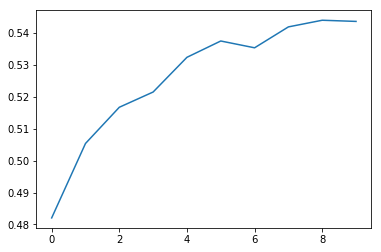

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_history(fscores):
    print("History:", fscores)
    print("Highest f-score:", max(fscores))
    plt.plot(fscores)
    plt.legend(loc='lower center', borderaxespad=0.)
    plt.show()

plot_history(evaluation_function.fscore)

<h3>Exercise 1</h3>
<br>
Try playing around with the neural network. You could, for example, try
- Different activation functions<br>
- Altering the learning rate<br>
- Use different optimizers<br>
- Adjusting the vocabulary size of the embeddings<br>
<br>
Activation functions and optimizers supported by Keras can be found here: https://keras.io/

<h3>Including the context</h3>

We then include the context by defining and building an RNN model which has the following layers:
<br>
- input: sequence of `sequence_length` integers corresponding to words
- embedding: pretrained mapping from integers to `vector_size`-dimensional vectors
- rnn: recurrent neural network, specifically LSTM, with `rnn_size`-dimensional state
- output: `class_count`-dimensional fully connected layer with softmax activation

In [15]:
from keras.layers import LSTM

example_count, sequence_len = vectorized_data_padded.shape
class_count = len(label_set)
rnn_size = 100

vector_size= pretrained.shape[1]

def build_rnn_model(example_count, sequence_len, class_count, rnn_size, vocabulary, vector_size, pretrained):
    inp=Input(shape=(sequence_len,))
    embeddings=Embedding(len(vocabulary), vector_size, mask_zero=False, trainable=False, weights=[pretrained])(inp)
    rnn = LSTM(rnn_size, activation='relu', return_sequences=True)(embeddings)
    outp=Dense(class_count, activation="softmax")(rnn)
    return Model(inputs=[inp], outputs=[outp])

rnn_model = build_rnn_model(example_count, sequence_len, class_count, rnn_size, vocabulary, vector_size, pretrained)

In [16]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 113)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 113, 300)          15000600  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 113, 100)          30100     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 113, 4)            404       
Total params: 15,031,104
Trainable params: 30,504
Non-trainable params: 15,000,600
_________________________________________________________________
None


<h3>Train an RNN model</h3>
<br>
We compile and train our model

In [17]:
optimizer=Adam(lr=0.001) # define the learning rate
rnn_model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", sample_weight_mode='temporal')

evaluation_function=EvaluateEntities()

# train
rnn_hist=rnn_model.fit(vectorized_data_padded,vectorized_labels_padded, sample_weight=weights, batch_size=100,verbose=2,epochs=10, callbacks=[evaluation_function])

Epoch 1/10
 - 36s - loss: 0.6107

Precision/Recall/F-score: 0.0 / 0.0 / 0.0
Epoch 2/10
 - 37s - loss: 0.2983

Precision/Recall/F-score: 0.700180458881155 / 0.5410358565737052 / 0.6104056635577032
Epoch 3/10
 - 36s - loss: 0.1825

Precision/Recall/F-score: 0.7224325603407478 / 0.6081673306772908 / 0.6603936837551373
Epoch 4/10
 - 36s - loss: 0.1523

Precision/Recall/F-score: 0.7101510067114094 / 0.6745019920318726 / 0.691867592970985
Epoch 5/10
 - 39s - loss: 0.1389

Precision/Recall/F-score: 0.7445462478184991 / 0.6798804780876494 / 0.7107455226988755
Epoch 6/10
 - 39s - loss: 0.1297

Precision/Recall/F-score: 0.7478184991273996 / 0.6828685258964143 / 0.7138692211578508
Epoch 7/10
 - 37s - loss: 0.1231

Precision/Recall/F-score: 0.7403663929248263 / 0.700398406374502 / 0.7198280274337191
Epoch 8/10
 - 37s - loss: 0.1179

Precision/Recall/F-score: 0.7666130144860888 / 0.6641434262948207 / 0.7117088269826021
Epoch 9/10
 - 37s - loss: 0.1139

Precision/Recall/F-score: 0.7412616339193382 /

Let's plot the f-scores

History: [0.0, 0.6104056635577032, 0.6603936837551373, 0.691867592970985, 0.7107455226988755, 0.7138692211578508, 0.7198280274337191, 0.7117088269826021, 0.7273465246067986, 0.7256581696615126]
Highest f-score: 0.7273465246067986


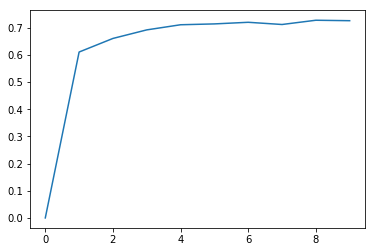

In [18]:
%matplotlib inline

plot_history(evaluation_function.fscore)

By including the context, our f-score increase by over 15 points!

<h3>Exercise 2</h3>
<br>
Try altering the structure of the network. You could, for example<br>
- Try different RNNs (LSTM, biLSTM)<br>
- Try using CNNs (hint: use the Conv1D layer, and the Dense layer afterwards needs a TimeDistributed wrapper layer)<br>
<br>
Again, the layers supported by Keras can be found from its documentation: https://keras.io/